# Machine Learning with Broad Stock Market Timeseries - a SARIMA Rollercoaster

<a href="" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<!-- @import "[TOC]" {cmd="toc" depthFrom=1 depthTo=6 orderedList=false} -->

![]()


## Prepare your Environment

Have a jupyter environment ready, and `pip install` these libraries:
- numpy
- pandas
- yfinance

You'll need access to [analysis_utils](./analysis_utils.py) library for common functions.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

import dotenv
%load_ext dotenv

import warnings
warnings.filterwarnings("ignore")

IS_KAGGLE = os.getenv('IS_KAGGLE', 'True') == 'True'

if IS_KAGGLE:
    # Kaggle confgs
    print('Running in Kaggle...')
    %pip install yfinance
    %pip install statsmodels
    %pip install seaborn
    %pip install itertools
    %pip install scikit-learn

    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
else:
    print('Running Local...')

import yfinance as yf
from analysis_utils import load_ticker_prices_ts_df, load_ticker_ts_df

os.getcwd()

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv
Running Local...


'c:\\Users\\adamd\\workspace\\quant_research'

# Data Collection and Preprocessing

Collect market time series data (like stock prices, trading volumes, etc.).
Clean the data to handle missing values, outliers, or anomalies.
Ensure the data is in a time series format, typically with a timestamp.

In [16]:
START_DATE = "2004-01-01"
END_DATE = "2023-12-31"
DATA_DIR = "data"
PRICE_FEATURES = ["Open", "High", "Low"]
INDEX = "Date"

os.makedirs(DATA_DIR, exist_ok=True)

TARGET_ETF = "SPY"  # S&P 500
RATES_INDEX = "^TNX"  # 10 Year Treasury Note Yield
VOLATILITY_INDEX = "^VIX"  # CBOE Volatility Index
MACRO_INDEX = "VEU"  # Vanguard FTSE All-World ex-US ETF

tickers_symbols = [
    TARGET_ETF,
    VOLATILITY_INDEX,
    RATES_INDEX,
    MACRO_INDEX,
]

tickers = {}
for symbol in tickers_symbols:
    cached_file_path = f"{DATA_DIR}/{symbol}-{START_DATE}-{END_DATE}.csv"

    try:
        if os.path.exists(cached_file_path):
            df = pd.read_csv(cached_file_path, index_col=INDEX)
            df.index = pd.to_datetime(df.index)
            assert len(df) > 0
        else:
            df = yf.download(
                symbol, start=START_DATE, end=END_DATE, progress=False, interval="1d"
            )
            assert len(df) > 0
            df.to_csv(cached_file_path)
        tickers[symbol] = df
    except Exception as e:
        print(f"Error with {symbol}: {e}")


sp500_df = tickers.get(TARGET_ETF)
vix_df = tickers.get(VOLATILITY_INDEX)
t10ytt_df = tickers.get(RATES_INDEX)
veu_df = tickers.get(MACRO_INDEX)

assert not sp500_df[PRICE_FEATURES].isna().any().any()

sp500_df.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-22,473.859985,475.380005,471.700012,473.649994,473.649994,67126600
2023-12-26,474.070007,476.579987,473.989990,475.649994,475.649994,55387000
2023-12-27,475.440002,476.660004,474.890015,476.510010,476.510010,68000300
2023-12-28,476.880005,477.549988,476.260010,476.690002,476.690002,77158100
2023-12-29,476.489990,477.029999,473.299988,475.309998,475.309998,122234100


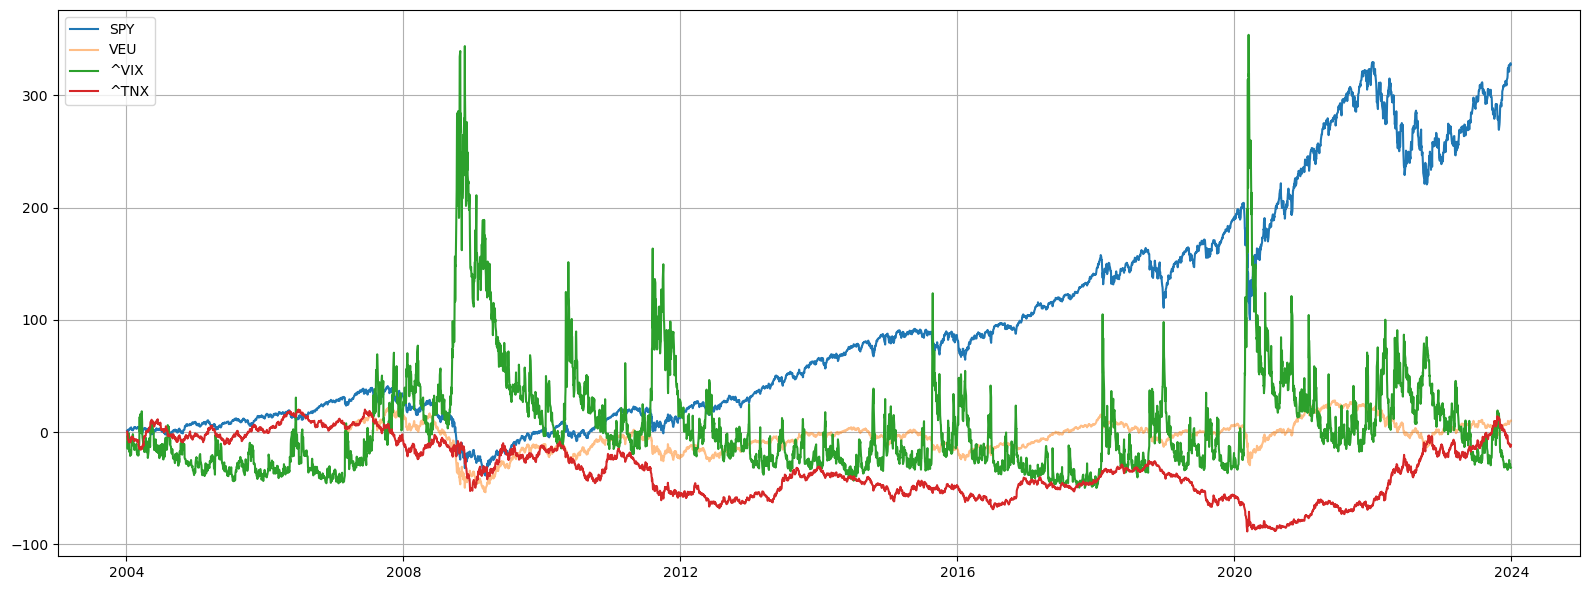

In [17]:
sp500_pr = ((1 + sp500_df["Close"].pct_change()).cumprod() - 1) * 100
veu_pr = ((1 + veu_df["Close"].pct_change()).cumprod() - 1) * 100
vix_pr = ((1 + vix_df["Close"].pct_change()).cumprod() - 1) * 100
tnx_pr = ((1 + t10ytt_df["Close"].pct_change()).cumprod() - 1) * 100

plt.figure(figsize=(16, 6))
plt.plot(sp500_pr, label=TARGET_ETF)
plt.plot(veu_pr, label=MACRO_INDEX, alpha=0.5)
plt.plot(vix_pr, label=VOLATILITY_INDEX)
plt.plot(tnx_pr, label=RATES_INDEX)

plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

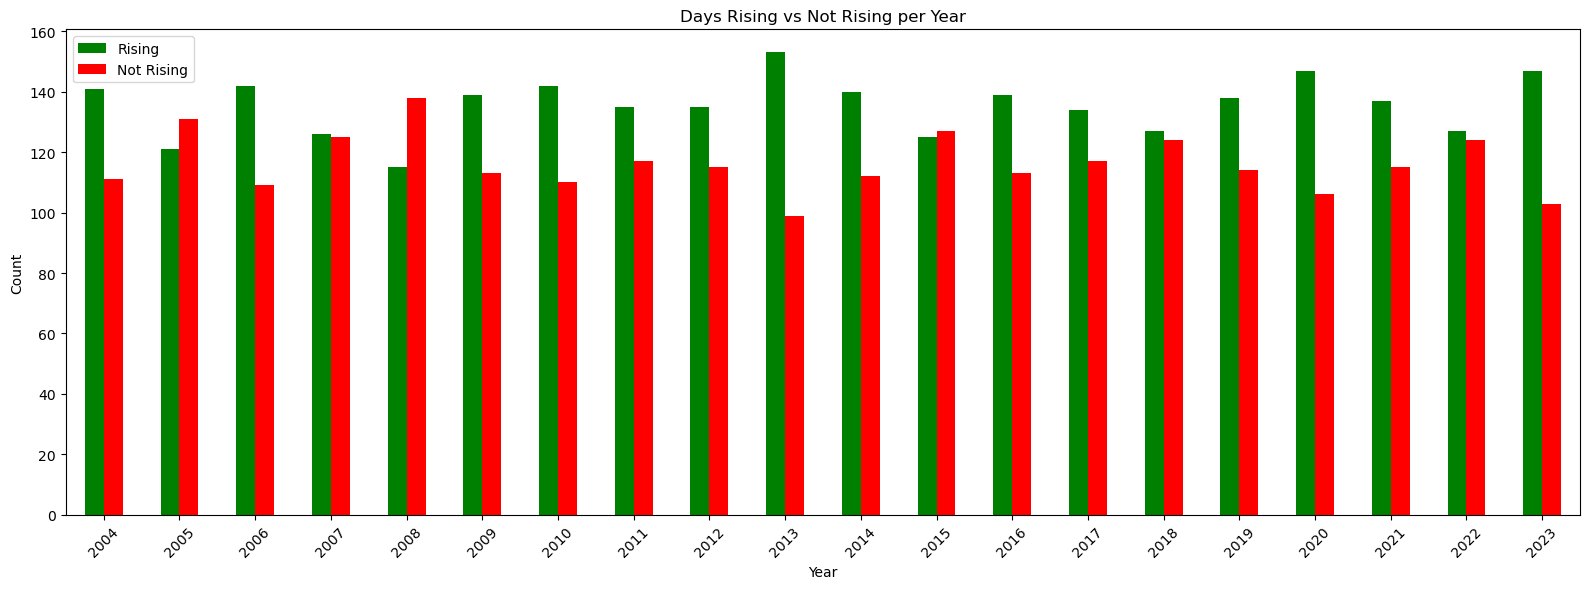

Baseline Accuracy: 53.85%


In [18]:
days_rising = sp500_df[sp500_df["Close"] > sp500_df["Open"]]
days_not_rising = sp500_df[sp500_df["Close"] <= sp500_df["Open"]]
days_rising_count = days_rising.groupby(days_rising.index.year).size()
days_not_rising_count = days_not_rising.groupby(days_not_rising.index.year).size()

total_days = sp500_df.groupby(sp500_df.index.year).size()
percentage_rising = (days_rising_count / total_days) * 100

yearly_counts = pd.DataFrame(
    {"Rising": days_rising_count, "Not Rising": days_not_rising_count}
)
yearly_counts.plot(kind="bar", color=["green", "red"], figsize=(16, 6))
plt.title("Days Rising vs Not Rising per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.tick_params(axis="x", rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Baseline Accuracy: {percentage_rising.mean():0.2f}%")

In [19]:
from tensorflow.keras.layers import (
    SpatialDropout1D,
    Dense,
    Conv1D,
    Layer,
    Normalization,
    Add,
    Input,
    Lambda,
)
from tensorflow.keras import Model


class TCNBlock(Layer):
    """
    TCN Residual Block that uses zero-padding to maintain `steps` value of the ouput equal to the one in the input.
    Residual Block is obtained by stacking togeather (2x) the following:
        - 1D Dilated Convolution
        - ReLu
        - Spatial Dropout
    And adding the input after trasnforming it with a 1x1 Conv
    forked and extended from: https://github.com/albertogaspar/dts/blob/master/dts/models/TCN.py
    """

    def __init__(
        self,
        filters=1,
        kernel_size=2,
        dilation_rate=None,
        kernel_initializer="glorot_normal",
        bias_initializer="glorot_normal",
        kernel_regularizer=None,
        bias_regularizer=None,
        use_bias=False,
        dropout_rate=0.0,
        id=None,
        **kwargs,
    ):
        """ "
        Arguments
            filters: Integer, the dimensionality of the output space
                (i.e. the number of output filters in the convolution).
            kernel_size: An integer or tuple/list of a single integer,
                specifying the length of the 1D convolution window.
            dilation_rate: an integer or tuple/list of a single integer, specifying
                the dilation rate to use for dilated convolution.
                Usually dilation rate increases exponentially with the depth of the network.
            activation: Activation function to use
                If you don't specify anything, no activation is applied
                (ie. "linear" activation: `a(x) = x`).
            use_bias: Boolean, whether the layer uses a bias vector.
            kernel_initializer: Initializer for the `kernel` weights matrix
            bias_initializer: Initializer for the bias vector
            kernel_regularizer: Regularizer function applied to the `kernel` weights matrix
            bias_regularizer: Regularizer function applied to the bias vector
                (see [regularizer](../regularizers.md)).
        # Input shape
            3D tensor with shape: `(batch, steps, n_features)`
        # Output shape
            3D tensor with shape: `(batch, steps, filters)`
        """
        super(TCNBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate

        # Capture feature set from the input
        self.conv1 = Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            use_bias=use_bias,
            bias_initializer=bias_initializer,
            bias_regularizer=bias_regularizer,
            kernel_initializer=kernel_initializer,
            kernel_regularizer=kernel_regularizer,
            padding="causal",
            dilation_rate=dilation_rate,
            activation="relu",
            name=f"Conv1D_1_{id}",
        )

        # Spatial dropout is specific to convolutions by dropping an entire timewindow,
        # not to rely too heavily on specific features detected by the kernels.
        self.dropout1 = SpatialDropout1D(
            dropout_rate, trainable=True, name=f"SpatialDropout1D_1_{id}"
        )
        # Capture a higher order feature set from the previous convolution
        self.conv2 = Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            use_bias=use_bias,
            bias_initializer=bias_initializer,
            bias_regularizer=bias_regularizer,
            kernel_initializer=kernel_initializer,
            kernel_regularizer=kernel_regularizer,
            padding="causal",
            dilation_rate=dilation_rate,
            activation="relu",
            name=f"Conv1D_2_{id}",
        )
        self.dropout2 = SpatialDropout1D(
            dropout_rate, trainable=True, name=f"SpatialDropout1D_2_{id}"
        )

        # The skip connection is an addition of the input to the block with the output of the second dropout layer.
        # Solves vanishing gradient, carries info from earlier layers to later layers, allowing gradients to flow across this alternative path.
        # Does not learn direct mappings, but differences (residuals) while keeping temporal context.
        # Note how it keeps dims intact with kernel 1.
        self.skip_out = Conv1D(
            filters=filters,
            kernel_size=1,
            activation="linear",
            name=f"Conv1D_skipconnection_{id}",
        )
        # This is the elementwise add for the residual connection and Conv1d 2's output
        self.residual_out = Add(name=f"residual_Add_{id}")

    def apply_block(self, inputs):
        x = self.conv1(inputs)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.dropout2(x)

        # Residual output by adding the inputs back:
        skip_out_x = self.skip_out(inputs)
        x = self.residual_out([x, skip_out_x])
        return x


def TCN(
    input_shape,
    output_horizon=1,
    num_filters=32,
    num_layers=1,
    kernel_size=2,
    dilation_rate=2,
    kernel_initializer="glorot_normal",
    bias_initializer="glorot_normal",
    kernel_regularizer=None,
    bias_regularizer=None,
    use_bias=False,
    dropout_rate=0.0,
):
    """
    Tensorflow TCN Model builder.
    forked and extended from: https://github.com/albertogaspar/dts/blob/master/dts/models/TCN.py
    see: https://www.tensorflow.org/api_docs/python/tf/keras/Model
    see: https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing#the_model_class
    see: https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/L2

    :param layers: int
        Number of layers for the network. Defaults to 1 layer.
    :param filters: int
        the number of output filters in the convolution. Defaults to 32.
    :param kernel_size: int or tuple
        the length of the 1D convolution window
    :param dilation_rate: int
        the dilation rate to use for dilated convolution. Defaults to 1.
    :param output_horizon: int
        the output horizon.
    """
    x = inputs = Input(shape=input_shape)
    for i in range(num_layers):
        block = TCNBlock(
            filters=num_filters,
            kernel_size=kernel_size,
            dilation_rate=dilation_rate**i,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            use_bias=use_bias,
            dropout_rate=dropout_rate,
            id=i,
        )
        x = block.apply_block(x)
    # Selects the last timestep and predict in the 1 DIM layer.
    x = Lambda(lambda x: x[:, -output_horizon:, 0], name="lambda_last_timestep")(x)
    outputs = Dense(output_horizon, name="Dense_singleoutput", activation="sigmoid")(x)

    model = Model(inputs=inputs, outputs=outputs, name="TCN")
    return model

# Data Preparation and Feature Engineering

In [20]:
from sklearn.preprocessing import FunctionTransformer


def encode_timewindows(data_df, features, target, window_size, horizon):
    """

    Create input and target windows suitable for TCN model.

    :param data: DataFrame with shape (n_samples, n_features)

    :param features: List of strings, names of the feature columns

    :param target: String, name of the target column

    :param window_size: int, length of the input sequence.

    :param horizon: int, forecasting horizon.

    :return: Array in the shape of (n_samples, n_steps, n_features)
    """

    X, y = [], []

    for i in tqdm(

        range(len(data_df) - window_size - horizon + 1), desc="Encoding Widows"

    ):

        input_window = data_df[features].iloc[i : i + window_size].values

        X.append(input_window)

        # Target window, note it predicts {horizon} steps ahead

        if horizon == 1:

            target_value = data_df[target].iloc[i + window_size]

        else:

            target_value = (

                data_df[target].iloc[i + window_size : i + window_size + horizon].values
            )

        y.append(target_value)

    return np.array(X), np.array(y)



MONTH_SINE = "month_sin"

MONTH_COS = "month_cos"

DAY_SINE = "day_sin"

DAY_COS = "day_cos"

Q_SINE = "quart_sin"

Q_COS = "quart_cos"

BIZ_SINE = "biz_sin"

BIZ_COS = "biz_cos"



def create_time_features(data_df):

    """
    Encodes time cyclic features for a dataset with monthly sampling.

    Including cyclic encoding for day and year.

    :param data_df: The timeseries with a date in the format YYYY-MM-DD as index.

    :return: data_df with added wave features for month, day, and year.
    """

    if not isinstance(data_df.index, pd.DatetimeIndex):

        raise ValueError("The DataFrame index must be a DateTimeIndex.")


    def _sin_transformer(period):

        return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

    def _cos_transformer(period):

        return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))


    months = data_df.index.month

    data_df[Q_SINE] = _sin_transformer(12 / 4).fit_transform(months)

    data_df[Q_COS] = _cos_transformer(12 / 4).fit_transform(months)

    data_df[BIZ_SINE] = _sin_transformer(12 * 5).fit_transform(months)

    data_df[BIZ_COS] = _cos_transformer(12 * 5).fit_transform(months)

    days = data_df.index.day

    data_df[DAY_SINE] = _sin_transformer(365).fit_transform(days)

    data_df[DAY_COS] = _cos_transformer(365).fit_transform(days)
    return data_df



FACTOR_COSTS = 0.0
FACTOR_SPREAD = 0.0
FACTOR_AVG_MOVE = (
    0  # tickers.get(TARGET_ETF)["Close"].tail(365*2).pct_change().mean() / 2
)

TARGET_FACTOR = FACTOR_COSTS + FACTOR_SPREAD + FACTOR_AVG_MOVE

TARGET = "open_lt_close"

TIME_FEATURES = [DAY_SINE, DAY_COS, BIZ_SINE, BIZ_COS, Q_SINE, Q_COS]

FEATURES = ["Volume", RATES_INDEX, MACRO_INDEX, VOLATILITY_INDEX]

EXT_FEATURES = FEATURES + PRICE_FEATURES + TIME_FEATURES

WINDOW_SIZE = 1 * 5 * 4 * 12  # 1 year trading

PREDICTION_HORIZON = 1  # next 1 trading day


print(f"target factor used: {TARGET_FACTOR}")


def create_features_df(tickers):
    """
    Create all exogenous features that lead to our target etf.
    """
    data_df = tickers.get(TARGET_ETF).copy()
    rates_df = tickers.get(RATES_INDEX)
    data_df[RATES_INDEX] = rates_df["High"]
    macro_df = tickers.get(MACRO_INDEX)
    data_df[MACRO_INDEX] = macro_df["High"]
    vix_df = tickers.get(VOLATILITY_INDEX)
    data_df[VOLATILITY_INDEX] = vix_df["High"]

    return data_df


def create_price_features(data_df):
    """

    Create Features:

        - if the trading day close is higher than the open.

        - price log returns
    """

    data_df[TARGET] = (

        (data_df["Open"] * (1 + TARGET_FACTOR)) < (data_df["Adj Close"])

    ).astype(int)

    data_df[PRICE_FEATURES] = np.log(

        data_df[PRICE_FEATURES] / data_df[PRICE_FEATURES].shift(1)

    ).fillna(0)

    return data_df



def prepare_data_and_windows(tickers, window=WINDOW_SIZE, horizon=PREDICTION_HORIZON):
    """

    Utility function to prepare the data.

    :data_df dataframe: dataframe with `window_size` months of data to predict the `window_size`+`horizon`.

    :param window_size: int, length of the input sequence

    :param horizon: int, forecasting horizon, defaults to 1

    :return: Array in the shape of (n_samples, n_steps, n_features)
    """

    data_df = create_features_df(tickers)

    data_df = create_price_features(data_df)


    normalizer = Normalization(axis=-1)

    normalizer.adapt(data_df[FEATURES])

    data_df_normalized = normalizer(data_df[FEATURES])

    data_df_normalized = pd.DataFrame(

        data_df_normalized.numpy(), columns=FEATURES, index=data_df.index
    )

    data_df_normalized = pd.concat(

        [data_df[TARGET], data_df[PRICE_FEATURES], data_df_normalized], axis=1
    )

    data_df_normalized = create_time_features(data_df_normalized)

    X, y = encode_timewindows(

        data_df_normalized,

        EXT_FEATURES,

        TARGET,

        window,

        horizon,
    )
    print(

        f"FEATURES: {EXT_FEATURES}, TARGET: '{TARGET}', window: {WINDOW_SIZE}, horizon: {PREDICTION_HORIZON}"
    )
    print(

        f"Shape unencoded (including target label and superflous features): {data_df.shape}"
    )

    print(f"Shape encoded (window and selected exog features only): {X.shape}")

    return X, y, normalizer



# Yes, we are using the whole dataset not the training dataset.

# See: https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

# we will tell keras to do a validation split, it will not fit on the validation data.

X, y, normalizer = prepare_data_and_windows(tickers)

print(f"Label shape encoded: {y.shape}")

print(f"Data shape: {X.shape}")

print(f"First window exog normalized: {X[0,  :]}")

print(f"First window targets: {y[:WINDOW_SIZE]}")

target factor used: 0.0


Encoding Widows: 100%|██████████| 4793/4793 [00:03<00:00, 1365.96it/s]


FEATURES: ['Volume', '^TNX', 'VEU', '^VIX', 'Open', 'High', 'Low', 'day_sin', 'day_cos', 'biz_sin', 'biz_cos', 'quart_sin', 'quart_cos'], TARGET: 'open_lt_close', window: 240, horizon: 1
Shape unencoded (including target label and superflous features): (5033, 10)
Shape encoded (window and selected exog features only): (4793, 240, 13)
Label shape encoded: (4793,)
Data shape: (4793, 240, 13)
First window exog normalized: [[-9.45073605e-01             nan             nan ...  9.94521895e-01
   8.66025404e-01 -5.00000000e-01]
 [-1.05514717e+00             nan             nan ...  9.94521895e-01
   8.66025404e-01 -5.00000000e-01]
 [-1.13664234e+00             nan             nan ...  9.94521895e-01
   8.66025404e-01 -5.00000000e-01]
 ...
 [-8.38877380e-01             nan             nan ...  3.09016994e-01
  -9.79717439e-16  1.00000000e+00]
 [-9.39971924e-01             nan             nan ...  3.09016994e-01
  -9.79717439e-16  1.00000000e+00]
 [-9.07755852e-01             nan             n

In [21]:
print(f"Last window exog normalized: {X[-1,  :]}")
print(f"Last window targets: {y[-WINDOW_SIZE:]}")

input_shape = (WINDOW_SIZE, X.shape[2])
input_shape

Last window exog normalized: [[-6.77250922e-01             nan             nan ...  9.94521895e-01
   8.66025404e-01 -5.00000000e-01]
 [-2.74999708e-01             nan             nan ...  9.94521895e-01
   8.66025404e-01 -5.00000000e-01]
 [-4.12948400e-01             nan             nan ...  9.94521895e-01
   8.66025404e-01 -5.00000000e-01]
 ...
 [-7.56605029e-01             nan             nan ...  3.09016994e-01
  -9.79717439e-16  1.00000000e+00]
 [-6.19310617e-01             nan             nan ...  3.09016994e-01
  -9.79717439e-16  1.00000000e+00]
 [-5.19629002e-01             nan             nan ...  3.09016994e-01
  -9.79717439e-16  1.00000000e+00]]
Last window targets: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 1

(240, 13)

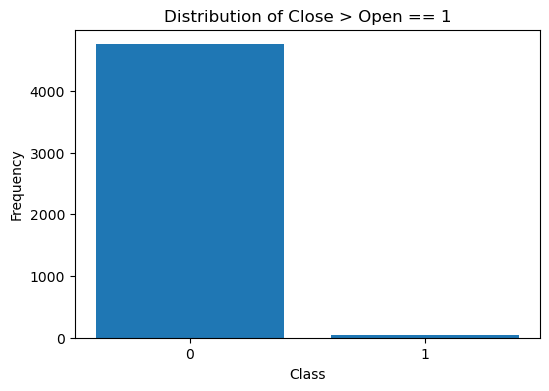

In [22]:
unique, counts = np.unique(y, return_counts=True)

plt.figure(figsize=(6, 4))
plt.bar(unique, counts, tick_label=unique)
plt.title("Distribution of Close > Open == 1")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.show()

In [23]:
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision
from tensorflow_addons.metrics import F1Score
from datetime import datetime
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit
import json

VAL_SPLIT = 0.15
EPOCHS = 100
BATCH_SIZE = 32
FILTER = 128
DROPRATE = 0.5
POOL_SIZE = 2
KERNEL_SIZE = 4
DILATION_RATE = 4
MAX_LAYERS = 4
L2_REG = 0.005
LEARN_RATE = 0.0001
MODEL_LOG_DIR = f'./logs/{datetime.now().strftime("%m%d-%H%M%S")}'
CV_SPLITS = 5
# See: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html
# See paper: https://www.mdpi.com/2076-3417/10/7/2322
GRID = {
    "num_filters": [32, 64, 128],
    "kernel_size": [2, 3, 4],
    "batch_size": [64, 128, 255],
    "epochs": [25, 50, 100, 300],
    "dilation_rate": [1, 2, 4],
    "dropout_rate": [0.1, 0.2, 0.3],
    "num_layers": [6, 5, 3],
    "l2_reg": [0.005, 0.001, 0.01],
    "learning_rate": [0.001, 0.01, 0.1],
}

print(f"Model logs for Tensorboard available here: {MODEL_LOG_DIR}")


def grid_search(X, y, param_grid=GRID, file_name="best_params.json"):
    """Runs for 3 days!!!"""

    def _create_model(hyperparams):
        model = TCN(
            input_shape=input_shape,
            output_horizon=PREDICTION_HORIZON,
            num_filters=hyperparams["num_filters"],
            kernel_size=hyperparams["kernel_size"],
            num_layers=hyperparams["num_layers"],
            dilation_rate=hyperparams["dilation_rate"],
            kernel_regularizer=L2(l2=hyperparams["l2_reg"]),
            bias_regularizer=L2(l2=hyperparams["l2_reg"]),
            dropout_rate=hyperparams["dropout_rate"],
        )
        optimizer = Adam(hyperparams["learning_rate"])
        model.compile(loss="mse", optimizer=optimizer, metrics=["mse", "mae", "mape"])
        return model

    def _save_best_params(best_params, best_loss, file_name="best_params.json"):
        with open(file_name, "w") as file:
            json.dump({"best_params": best_params, "best_loss": best_loss}, file)

    grid = list(ParameterGrid(param_grid))
    best_model = None
    best_loss = np.inf
    best_params = None

    for params in tqdm(grid, desc="Grid Search.."):
        model = _create_model(params)
        callbacks = [EarlyStopping(patience=5, monitor="val_loss")]
        history = model.fit(
            X,
            y,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=VAL_SPLIT,
            verbose=0,
            callbacks=callbacks,
        )
        val_loss = np.min(history.history["val_loss"])

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model
            best_params = params
            _save_best_params(best_params, best_loss, file_name)

    return best_model, best_loss


def build_tcn(input_shape, X, y, Xt=None, yt=None, val_split=VAL_SPLIT):
    model = TCN(
        input_shape=input_shape,
        output_horizon=PREDICTION_HORIZON,
        num_filters=FILTER,
        kernel_size=KERNEL_SIZE,
        num_layers=MAX_LAYERS,
        dilation_rate=DILATION_RATE,
        kernel_regularizer=L2(l2=L2_REG),
        bias_regularizer=L2(l2=L2_REG),
    )
    optimizer = Adam(LEARN_RATE)
    metrics = [Precision()]
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics)
    callbacks = [
        EarlyStopping(patience=25, monitor="val_precision", restore_best_weights=True),
        TensorBoard(log_dir=MODEL_LOG_DIR),
    ]
    history = model.fit(
        X,
        y,
        validation_data=(Xt, yt) if Xt is not None else None,
        validation_split=val_split if Xt is None else None,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=1,
    )
    return model, history


def train_cv_model(X, y, input_shape, n_splits=CV_SPLITS):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = build_tcn(input_shape, X_train, y_train, X_test, y_test)


model, history = build_tcn(input_shape, X, y)
model.summary()

Model logs for Tensorboard available here: ./logs/0127-182901
Epoch 1/100
128/128 [==============================] - 52s 384ms/step - loss: nan - precision_1: 0.0000e+00 - val_loss: nan - val_precision_1: 0.0000e+00
Epoch 2/100
 17/128 [==>...........................] - ETA: 40s - loss: nan - precision_1: 0.0000e+00

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.models import load_model

MODEL_DIR = f"./models/{datetime.now().strftime('%Y%m%d-%H')}"

os.makedirs(MODEL_DIR, exist_ok=True)
assert os.path.exists(MODEL_DIR)

model.save(f"{MODEL_DIR}/tcn.h5")
model = load_model(f"{MODEL_DIR}/tcn.h5")
model.summary()

In [ ]:
VAL_SIZE = round(len(X) * VAL_SPLIT)

train_data = X[:-VAL_SIZE]
test_data = X[-VAL_SIZE:]
ytrain_data = y[:-VAL_SIZE]
ytest_data = y[-VAL_SIZE:]
print(f"Test data shape: {ytest_data.shape}")
print(f"Test data 1 horizon sample: {ytest_data[0]}")

y_pred = model.predict(train_data)
yt_pred = model.predict(test_data)

print(f"Prediction shape: {yt_pred.shape}")
print(f"Predition 1 horizon sample: {yt_pred[0].flatten()}")

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred_b = (y_pred > 0.5).astype(int).flatten()
yt_pred_b = (yt_pred > 0.5).astype(int).flatten()

y_flat = ytrain_data.flatten()
yt_flat = ytest_data.flatten()

print(f"shapes y: {ytrain_data.shape} and yt_pred: {ytest_data.shape}")
print(f"shapes y_pred: {y_pred.shape} and yt_pred: {yt_pred.shape}")
print(f"Next + binary shapes y_pred: {y_pred_b.shape} and yt_pred: {yt_pred_b.shape}")

accuracy_train = accuracy_score(y_flat, y_pred_b)
accuracy_test = accuracy_score(yt_flat, yt_pred_b)
precision_train = precision_score(y_flat, y_pred_b)
precision_test = precision_score(yt_flat, yt_pred_b)
recall_train = recall_score(y_flat, y_pred_b)
recall_test = recall_score(yt_flat, yt_pred_b)
f1_train = f1_score(y_flat, y_pred_b)
f1_test = f1_score(yt_flat, yt_pred_b)


metrics_df = pd.DataFrame(
    {
        "Accuracy": [accuracy_train, accuracy_test],
        "Precision": [precision_train, precision_test],
        "Recall": [recall_train, recall_test],
        "F1 Score": [f1_train, f1_test],
    },
    index=["Train", "Test"],
)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(history.history["loss"], label="Train loss")
axs[0].plot(history.history["val_loss"], label="Validation loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(
    history.history["precision"],
    label="Train precision",
    linestyle="-.",
)
axs[1].plot(
    history.history["val_precision"],
    label="Test precision",
    linestyle="-",
)
axs[1].axhline(
    precision_train, linestyle="--", label="Train Precision", alpha=0.5, color="r"
)
axs[1].axhline(
    precision_test, linestyle="-", label="Test Precision", alpha=0.5, color="r"
)
axs[1].axhline(f1_train, linestyle="--", label="Train F1", alpha=0.5, color="g")
axs[1].axhline(f1_test, linestyle="-", label="Test F1", alpha=0.5, color="g")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy/Precision")
axs[1].legend()

metrics_df

# Conclusion




![]()

## References

- [YFinance Github](https://github.com/ranaroussi/yfinance)
- [Vanguard All World excluding US](https://investor.vanguard.com/investment-products/etfs/profile/veu)


## Github

Article here is also available on [Github]()

Kaggle notebook available [here]()


## Media

All media used (in the form of code or images) are either solely owned by me, acquired through licensing, or part of the Public Domain and granted use through Creative Commons License.

## CC Licensing and Use

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.